In [1]:
"""Demonstrate how probabilistic solvers work via conditioning on constraints."""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend

from probdiffeq import ivpsolve, ivpsolvers, stats, taylor

### Quick Start quide

In [15]:
"""Solve the logistic equation."""

@jax.jit
def vf(y, *, t):  # noqa: ARG001
    """Evaluate the dynamics of the logistic ODE."""
    return y * (1 - y)


u0 = jnp.asarray([0.01])
t0, t1 = 0.0, 10.0
N = 20
h = (t1 - t0) / N
grid = jnp.linspace(t0, t1, N + 1) #for naive fixed grid computation


# this computes taylor expansion of vf, up to order num, arround u0, and return the coefficient
tcoeffs = taylor.odejet_padded_scan(lambda y: vf(y, t=t0), (u0,), num=2)

# sets up the prior which is a q-times IWP where q is defined by the length of tcoeffs. 
# The return should be the discretized SSM specified by (A, b, Q)
# what is init?: m_0 and P_0^1/2 in this case of the IWP m_0 is exactly tcoeffs and P_0ˆ1/2 is zeros
# what is ibm?: idea: continous? IWP i.e. IBM that allows to compute transitons for differnet time intervals
# what is ssm?: idea: discretized (and linearized?) SSM from the IBM
init, ibm, ssm = ivpsolvers.prior_wiener_integrated(tcoeffs, ssm_fact="dense")

# Build a solver
ts = ivpsolvers.correction_ts1(vf, ssm=ssm, ode_order=1)
strategy = ivpsolvers.strategy_filter(ssm=ssm)
solver = ivpsolvers.solver(ssm=ssm, strategy=strategy, prior=ibm, correction=ts)
#adaptive_solver = ivpsolvers.adaptive(solver, ssm=ssm)



solution = ivpsolve.solve_fixed_grid(init, grid=grid, solver=solver, ssm=ssm)

# Look at the solution
print(f"\ninitial = {jax.tree.map(jnp.shape, init)}")
print(f"\nsolution = {jax.tree.map(jnp.shape, solution)}")


initial = Normal(mean=(3,), cholesky=(3, 3))

solution = IVPSolution(t=(21,), u=[(21, 1), (21, 1), (21, 1)], u_std=[(21, 1), (21, 1), (21, 1)], output_scale=(20,), marginals=Normal(mean=(21, 3), cholesky=(21, 3, 3)), posterior=Normal(mean=(21, 3), cholesky=(21, 3, 3)), num_steps=(20,), ssm=FactImpl(name='dense', prototypes=<probdiffeq.impl._prototypes.DensePrototype object at 0x14e13de50>, normal=<probdiffeq.impl._normal.DenseNormal object at 0x14e13d6d0>, stats=<probdiffeq.impl._stats.DenseStats object at 0x14e13dbd0>, linearise=<probdiffeq.impl._linearise.DenseLinearisation object at 0x14e13d810>, conditional=<probdiffeq.impl._conditional.DenseConditional object at 0x14e13dd10>, num_derivatives=2, unravel=<jax._src.util.HashablePartial object at 0x14e57a6f0>))


In [3]:
tcoeffs

[Array([0.01], dtype=float32),
 Array([0.0099], dtype=float32),
 Array([0.009702], dtype=float32)]

In [4]:
init

Normal(mean=Array([0.01    , 0.0099  , 0.009702], dtype=float32), cholesky=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))

In [ ]:
from probdiffeq.backend import tree_util

ode_shape = tree_util.ravel_pytree(tcoeffs[0])[0].shape #ode_schape is d
flat, unravel = tree_util.ravel_pytree(tcoeffs) #same as jax.flatten_util.ravel_pytree(tcoeffs)

In [ ]:
ssm.prototypes.output_scale() # is this sigma?

Array(1., dtype=float32)

u_array_squeezed shape: (3, 21)
u_std_squeezed shape: (3, 21)


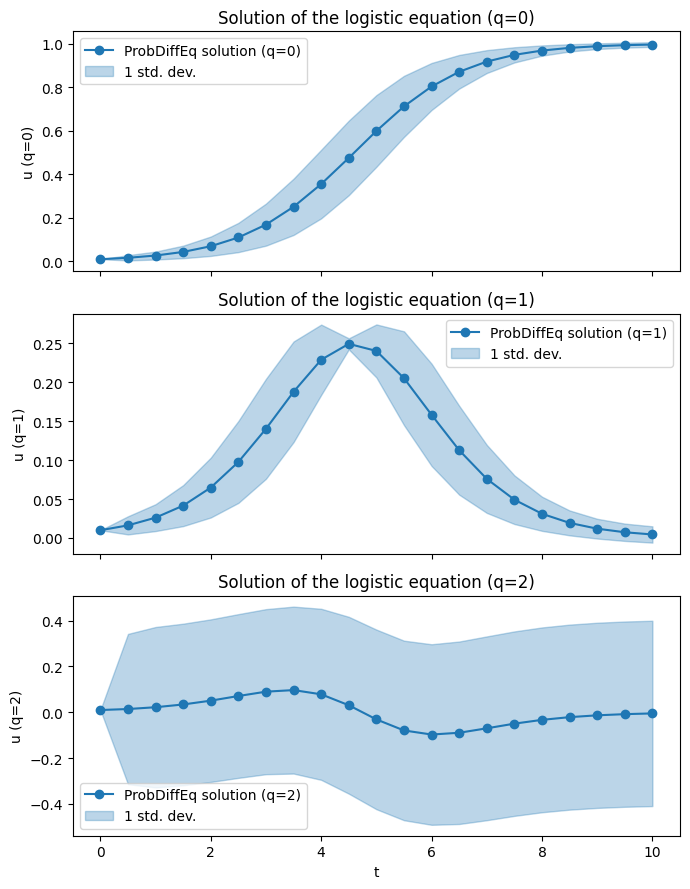

In [26]:
# Convert solution.u (a list) to a JAX array and squeeze to remove singleton dimensions
u_array = jnp.asarray(solution.u)
u_array_squeezed = jnp.squeeze(u_array)  # shape: (q, N+1) if q > 1
print("u_array_squeezed shape:", u_array_squeezed.shape)

# Convert solution.t to a JAX array if it's not already
t_array = jnp.asarray(solution.t)

# Convert solution.u_std to a JAX array and squeeze to match u_array_squeezed
u_std_array = jnp.asarray(solution.u_std)
u_std_squeezed = jnp.squeeze(u_std_array)  # shape: (q, N+1) if q > 1
print("u_std_squeezed shape:", u_std_squeezed.shape)

q = u_array_squeezed.shape[0] if u_array_squeezed.ndim > 1 else 1

fig, axes = plt.subplots(q, 1, figsize=(7, 3 * q), sharex=True)
if q == 1:
    axes = [axes]

for i in range(q):
    ax = axes[i]
    u_i = u_array_squeezed[i] if q > 1 else u_array_squeezed
    std_i = u_std_squeezed[i] if q > 1 else u_std_squeezed
    ax.plot(t_array, u_i, marker='o', label=f'ProbDiffEq solution (q={i})')
    ax.fill_between(
        t_array,
        u_i - std_i,
        u_i + std_i,
        color='C0',
        alpha=0.3,
        label='1 std. dev.'
    )
    ax.set_ylabel(f'u (q={i})')
    ax.legend()
    ax.set_title(f'Solution of the logistic equation (q={i})')

axes[-1].set_xlabel('t')
plt.tight_layout()
plt.show()


### Lotka Volterra from probdiffeq documentation

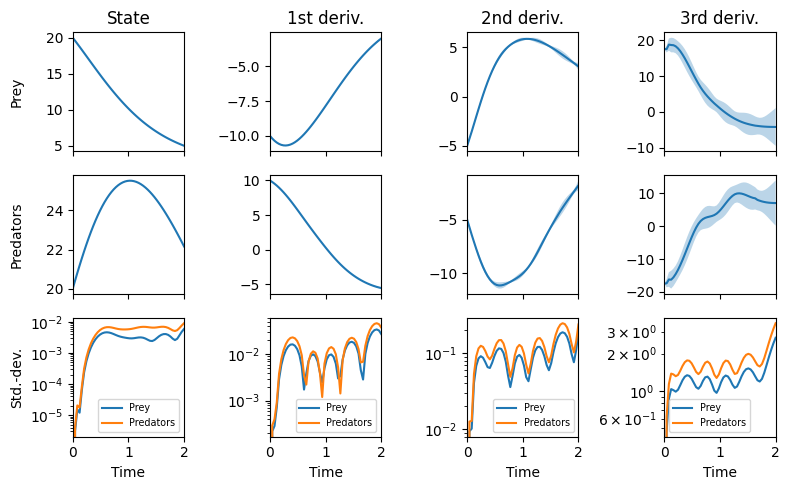

In [8]:
def vf(y, *, t):  # noqa: ARG001
    """Evaluate the Lotka-Volterra vector field."""
    y0, y1 = y[0], y[1]

    y0_new = 0.5 * y0 - 0.05 * y0 * y1
    y1_new = -0.5 * y1 + 0.05 * y0 * y1
    return jnp.asarray([y0_new, y1_new])


t0 = 0.0
t1 = 2.0
u0 = jnp.asarray([20.0, 20.0])


# Set up a solver
# To all users: Try replacing the fixedpoint-smoother with a filter!
tcoeffs = taylor.odejet_padded_scan(lambda y: vf(y, t=t0), (u0,), num=3)
init, ibm, ssm = ivpsolvers.prior_wiener_integrated(tcoeffs, ssm_fact="blockdiag")
ts = ivpsolvers.correction_ts1(vf, ssm=ssm)
strategy = ivpsolvers.strategy_fixedpoint(ssm=ssm)
solver = ivpsolvers.solver_mle(strategy, prior=ibm, correction=ts, ssm=ssm)
adaptive_solver = ivpsolvers.adaptive(solver, atol=1e-1, rtol=1e-1, ssm=ssm)

# Solve the ODE
ts = jnp.linspace(t0, t1, endpoint=True, num=50)
sol = ivpsolve.solve_adaptive_save_at(
    init, save_at=ts, dt0=0.1, adaptive_solver=adaptive_solver, ssm=ssm
)

# Calibrate
marginals = stats.calibrate(sol.marginals, output_scale=sol.output_scale, ssm=ssm)
std = ssm.stats.standard_deviation(marginals)
u_std = ssm.stats.qoi_from_sample(std)

# Plot the solution
fig, axes = plt.subplots(
    nrows=3,
    ncols=len(tcoeffs),
    sharex="col",
    tight_layout=True,
    figsize=(len(u_std) * 2, 5),
)
for i, (u_i, std_i, ax_i) in enumerate(zip(sol.u, u_std, axes.T)):
    # Set up titles and axis descriptions
    if i == 0:
        ax_i[0].set_title("State")
        ax_i[0].set_ylabel("Prey")
        ax_i[1].set_ylabel("Predators")
        ax_i[2].set_ylabel("Std.-dev.")
    elif i == 1:
        ax_i[0].set_title(f"{i}st deriv.")
    elif i == 2:
        ax_i[0].set_title(f"{i}nd deriv.")
    elif i == 3:
        ax_i[0].set_title(f"{i}rd deriv.")
    else:
        ax_i[0].set_title(f"{i}th deriv.")

    ax_i[-1].set_xlabel("Time")

    for m, std, ax in zip(u_i.T, std_i.T, ax_i):
        # Plot the mean
        ax.plot(sol.t, m)

        # Plot the standard deviation
        lower, upper = m - 1.96 * std, m + 1.96 * std
        ax.fill_between(sol.t, lower, upper, alpha=0.3)
        ax.set_xlim((jnp.amin(ts), jnp.amax(ts)))

    ax_i[2].semilogy(sol.t, std_i[:, 0], label="Prey")
    ax_i[2].semilogy(sol.t, std_i[:, 1], label="Predators")
    ax_i[2].legend(fontsize="x-small")

fig.align_ylabels()
plt.show()

### SIR model

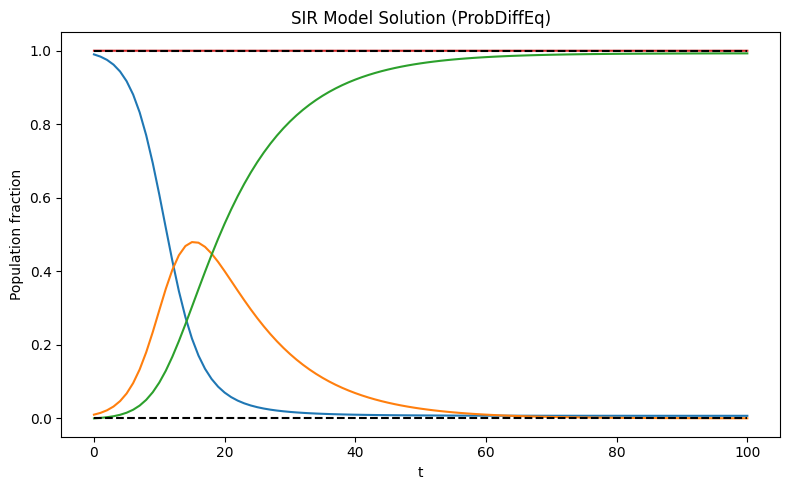

In [42]:
def vf(y, *, t, beta=0.5, gamma=0.1):  # noqa: ARG001
    """Evaluate the Lotka-Volterra vector field."""
    y0, y1, y3 = y[0], y[1], y[2]

    y0_new = -1.*beta*y0*y1
    y1_new = beta*y0*y1 - gamma*y1
    y2_new = gamma * y1
    return jnp.asarray([y0_new, y1_new, y2_new])


u0 = jnp.asarray([0.99, 0.01, 0.])
t0, t1 = 0.0, 100.0
N = 100
h = (t1 - t0) / N
grid = jnp.linspace(t0, t1, N + 1) #for naive fixed grid computation


tcoeffs = taylor.odejet_padded_scan(lambda y: vf(y, t=t0), (u0,), num=2)

init, ibm, ssm = ivpsolvers.prior_wiener_integrated(tcoeffs, ssm_fact="dense")

# Build a solver
ts = ivpsolvers.correction_ts1(vf, ssm=ssm, ode_order=1)
strategy = ivpsolvers.strategy_filter(ssm=ssm)
solver = ivpsolvers.solver(ssm=ssm, strategy=strategy, prior=ibm, correction=ts)
#adaptive_solver = ivpsolvers.adaptive(solver, ssm=ssm)

solution = ivpsolve.solve_fixed_grid(init, grid=grid, solver=solver, ssm=ssm)

# Look at the solution
#print(f"\ninitial = {jax.tree.map(jnp.shape, init)}")
#print(f"\nsolution = {jax.tree.map(jnp.shape, solution)}")

u_array = jnp.asarray(solution.u)  
t_array = jnp.asarray(solution.t)  
u_plot = u_array[0, :, :]   

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_array, u_plot)
ax.plot(t_array, jnp.sum(u_plot, axis=1))
ax.plot(t_array, jnp.ones_like(t_array), linestyle='--', color='black')
ax.plot(t_array, jnp.zeros_like(t_array), linestyle='--', color='black')
ax.set_xlabel('t')
ax.set_ylabel('Population fraction')
ax.set_title('SIR Model Solution (ProbDiffEq)')
plt.tight_layout()
plt.show()


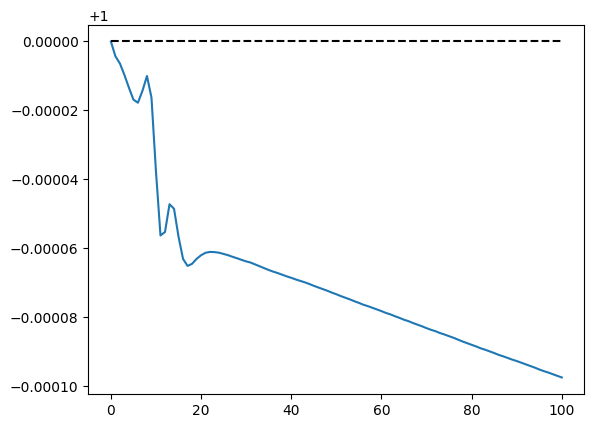

In [45]:
plt.figure()
plt.plot(t_array, jnp.sum(u_plot, axis=1))
plt.plot(t_array, jnp.ones_like(t_array), linestyle='--', color='black')
plt.show()

Nicos code is way more accurate than my naive impelentation, however conservation still not holds exactly, so let't test if there is some knowledge to be gained from the conservation law. 

The improved stability might be due the points in https://www.jmlr.org/papers/volume25/20-1423/20-1423.pdf

In [ ]:
@jax.jit
def vf(y, *, t):
    return y * (1 - y)

@jax.jit
def g(x, E0, E1, A, c):
    return jnp.concat([
            E1 @ x - vf(E0 @ x),
            A @ x + c, #additional information
            E1 @ x
    ])

data = jnp.array([2.0, 3.3, 4.1, 12.4, 33.0, 12.1])

#setup
tcoeffs = taylor.odejet_padded_scan(lambda y: vf(y, t=t0), (u0,), num=2)
init, ibm, ssm = ivpsolvers.prior_wiener_integrated(tcoeffs, ssm_fact="dense")
ts = ivpsolvers.correction_ts1(vf, g, ssm=ssm, ode_order=1)
strategy = ivpsolvers.strategy_filter(ssm=ssm)
solver = ivpsolvers.solver(ssm=ssm, strategy=strategy, prior=ibm, correction=ts, data=data)

solution = ivpsolve.solve_fixed_grid(init, grid=grid, solver=solver, ssm=ssm)